# Example 5: Star-shaped scalings in 2d using radial FEM

Similar to [before](star_shaped.ipynb) we consider a two-dimensional example, namely $\Omega:=\mathbb R^2\setminus B_{R}(\mathbf x_0)$, some center $\mathbf x_0\in B_1(0)$ and radius $R$.
This time we allow an arbitrary boundary $\Gamma$ which is star-shaped with respect to the origin such that $B_R(\mathbf x_0)$ is contained in the interior of $\Gamma$.

We choose star-shaped coordinates given by

$$\mathbf x(\xi,\hat x):=(1+\xi)\hat x,$$
(cf. [Section 7.1.2](dissertation_wess.pdf#subsection.7.1.2)).

Again, we create the according mesh and set some parameters.

Moreover, this time we use a radial discretization by one-dimensional finite elements. The matrices are generated using a 1d mesh.

In [7]:
from ngsolve import *
from netgen.geom2d import *
from nonlin_arnoldis import *
from ngsolve.webgui import Draw
from numpy import array,sqrt,loadtxt
from matplotlib.pyplot import plot,show,xlim,ylim,legend

maxh = 0.1     #mesh-size
sigma = 1+2j   #complex scaling paramter
order = 5      #fem order
shift = 4-0.5j      #shift for Arnoldi algorithm
center = (0.2,0)    #center of inner circle
R = 0.5            #radius of inner circle

#create geometry
geo = SplineGeometry()
geo.AddRectangle((-0.8,-0.7),(1,1),leftdomain=1,rightdomain=0,bc='Gamma')
geo.AddCircle(center,R,leftdomain=0,rightdomain=1,bc='inner')
#geo.AddCircle((0,0),1,leftdomain=1,rightdomain=0,bc='Gamma')
#geo.AddCircle(center,R,leftdomain=0,rightdomain=1,bc='inner')

#create mesh
mesh = Mesh(geo.GenerateMesh(maxh=maxh))
mesh.Curve(2*order)
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

The weak formulation after a re-scaling of the solution and testfunction in the exterior is given by [(7.10)](dissertation_wess.pdf#equation.7.2.10).

Contrary to [polar coordinates](circular.ipynb) this time we also need the normal vecter $\mathbf n(\hat x)$ and the vector $\mathbf v(\hat x)=\hat x$.

In [8]:
n = specialcf.normal(2)
v = CoefficientFunction((x,y))

For this first simple example we again choose a frequency independent scaling
$$\sigma(\omega):=\sigma_0\in\mathbb C.$$

We start by creating the radial matrices using a 1d finite element space:

In [9]:
from fem1d import *
from numpy import array

mesh1d = Mesh(geo1d(0,1).GenerateMesh(maxh=0.1))
fes1d = H1(mesh1d,order=order,complex=True)

u,u_ = fes1d.TnT()

fem1d_mass_surf = array(BilinearForm(u*u_*ds('left')).Assemble().mat.ToDense())

fem1d_mass = array(BilinearForm(u*u_*dx).Assemble().mat.ToDense())
fem1d_mass_x = array(BilinearForm(x*u*u_*dx).Assemble().mat.ToDense())
fem1d_mass_xx = array(BilinearForm(x*x*u*u_*dx).Assemble().mat.ToDense())


#fem1d_drift = array(BilinearForm(u*grad(u_)*dx).Assemble().mat.ToDense())
#fem1d_drift_x = array(BilinearForm(x*u*grad(u_)*dx).Assemble().mat.ToDense())
#fem1d_drift_xx = array(BilinearForm(x*x*u*grad(u_)*dx).Assemble().mat.ToDense())

fem1d_drift = array(BilinearForm(grad(u)*u_*dx).Assemble().mat.ToDense())
fem1d_drift_x = array(BilinearForm(x*grad(u)*u_*dx).Assemble().mat.ToDense())
fem1d_drift_xx = array(BilinearForm(x*x*grad(u)*u_*dx).Assemble().mat.ToDense())

fem1d_laplace = array(BilinearForm(grad(u)*grad(u_)*dx).Assemble().mat.ToDense())
fem1d_laplace_x = array(BilinearForm(x*grad(u)*grad(u_)*dx).Assemble().mat.ToDense())
fem1d_laplace_xx = array(BilinearForm(x*x*grad(u)*grad(u_)*dx).Assemble().mat.ToDense())


S_rad_1 = 1/sigma*fem1d_laplace+2*fem1d_laplace_x+sigma*fem1d_laplace_xx-sigma/4*fem1d_mass-1/2*fem1d_mass_surf

S_rad_2 = sigma*fem1d_mass

D_rad = fem1d_drift+sigma*fem1d_drift_x

M_rad = sigma * (fem1d_mass+2*sigma*fem1d_mass_x+sigma**2*fem1d_mass_xx)

used dof inconsistency
(silence this warning by setting BilinearForm(...check_unused=False) )


next we generate the large finite element space for implementing our [tensor-product method](tp_disc.ipynb).

In [10]:
N = fes1d.ndof

Gamma = mesh.Boundaries('Gamma')

fes_int = H1(mesh,order=order,complex=True)
fes_surf = H1(mesh,order=order,complex=True,definedon=Gamma)

fes = ProductSpace(fes_int,*( (N-1)*[fes_surf]) )

Now we can assemble our bilinear forms.

In [11]:


ds_g = ds(definedon=Gamma)
p,q = fes.TnT()
p_int,q_int = p[0],q[0]
S = BilinearForm(
    grad(p_int)*grad(q_int)*dx
    +sum(S_rad_1[i,j]*1/(n*v)*p[j]*q[i]*ds_g
       for i in range(N) for j in range(N) if abs(S_rad_1[i,j])>0)
    -sum(D_rad[i,j]*1/(n*v)*(v*p[i].Trace().Deriv())*q[j]*ds_g
       for i in range(N) for j in range(N) if abs(D_rad[i,j])>0)
    -sum(D_rad[i,j]*1/(n*v)*p[j]*(v*q[i].Trace().Deriv())*ds_g
       for i in range(N) for j in range(N) if abs(D_rad[i,j])>0)
    +sum(S_rad_2[i,j]*(v*v)/(n*v)*p[j].Trace().Deriv()*q[i].Trace().Deriv()*ds_g
       for i in range(N) for j in range(N) if abs(S_rad_2[i,j])>0)
    -sum(S_rad_2[i,j]*1/(2*n*v)*((p[j].Trace().Deriv()*v)*q[i]+p[j]*(v*q[i].Trace().Deriv()))*ds_g
       for i in range(N) for j in range(N) if abs(S_rad_2[i,j])>0)
    ,symmetric=True).Assemble()

M = BilinearForm(
    -p_int*q_int*dx
    -sum(M_rad[i,j]*(n*v)*p[j]*q[i]*ds_g
       for i in range(N) for j in range(N) if abs(M_rad[i,j])>0)
    ,symmetric=True).Assemble()


Finally, we solve the resulting eigenvalue problem.

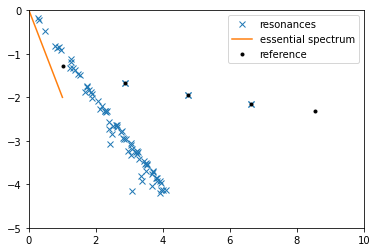

In [12]:
gf = GridFunction(fes,multidim=10)

#lam = sqrt(array(ArnoldiSolver(S.mat,M.mat,freedofs=fes.FreeDofs(),vecs=gf.vecs,shift=shift**2)))
lam = sqrt(array(PolyArnoldiSolver([S.mat,M.mat],shift**2,200,nevals=80,vecs=gf.vecs,inversetype='sparsecholesky',freedofs=fes.FreeDofs())))

plot(lam.real,lam.imag,'x',label='resonances')
plot([0,5*(1/sigma).real],[0,5*(1/sigma).imag],label='essential spectrum')

#load reference resonances from file
loaded=loadtxt('dhankel_1_zeros.out')
ref=(loaded[:,0]+1j*loaded[:,1])/R
    
plot(ref.real,ref.imag,'.k',label='reference')

xlim((0,10))
ylim((-5,0))
legend()
Draw(gf.components[0])